In [1]:
import psycopg
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import pandas as pd
import statsmodels.api as sm



In [2]:
df = pd.read_csv("backing_it_up.csv", index_col = False).drop(columns = ['Unnamed: 0'])

In [3]:
df.head()

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count
0,1,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,2010-02-12,2010-06-29,83.0,49,144,53.0,254287.0
1,2,Please Give,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,2010-04-30,2010-10-19,90.0,86,140,64.0,11567.0
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0
3,4,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",NaN,"Classics, Drama",Sidney Lumet,2057-04-13,2001-03-06,95.0,100,51,97.0,105000.0
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0


Getting an overview of data types and null counts

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            16638 non-null  int64  
 1   movie_title         16638 non-null  object 
 2   movie_info          16614 non-null  object 
 3   rating              11776 non-null  object 
 4   genre               16621 non-null  object 
 5   directors           16524 non-null  object 
 6   in_theaters_date    15823 non-null  object 
 7   on_streaming_date   16636 non-null  object 
 8   runtime_in_minutes  16483 non-null  float64
 9   critic_rating       16638 non-null  int64  
 10  critic_count        16638 non-null  int64  
 11  audience_rating     16381 non-null  float64
 12  audience_count      16386 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 1.7+ MB


##### There is no clear way to discover the release dates for the movies with missing release date values
##### In order to proceed forward with analyses that require the date values, we will drop the records with missing release theatre dates

In [5]:
len(df)

16638

In [6]:
df.head()

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count
0,1,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,2010-02-12,2010-06-29,83.0,49,144,53.0,254287.0
1,2,Please Give,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,2010-04-30,2010-10-19,90.0,86,140,64.0,11567.0
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0
3,4,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",NaN,"Classics, Drama",Sidney Lumet,2057-04-13,2001-03-06,95.0,100,51,97.0,105000.0
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0


In [7]:
df_no_nulls = df.dropna()

In [8]:
len(df_no_nulls)

11346

In [9]:
df_no_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11346 entries, 0 to 16637
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            11346 non-null  int64  
 1   movie_title         11346 non-null  object 
 2   movie_info          11346 non-null  object 
 3   rating              11346 non-null  object 
 4   genre               11346 non-null  object 
 5   directors           11346 non-null  object 
 6   in_theaters_date    11346 non-null  object 
 7   on_streaming_date   11346 non-null  object 
 8   runtime_in_minutes  11346 non-null  float64
 9   critic_rating       11346 non-null  int64  
 10  critic_count        11346 non-null  int64  
 11  audience_rating     11346 non-null  float64
 12  audience_count      11346 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 1.2+ MB


In [10]:
def fix_the_year(year_val):
    if (year_val > 2024):
        year_val_str = str(year_val)
        year_val_fixed = int( '19' + str(year_val_str[2:]) )
        return year_val_fixed
    else:
        return year_val
    

In [11]:
df_no_nulls.in_theaters_date

0        2010-02-12
1        2010-04-30
2        1979-10-05
4        2054-01-01
5        2008-03-07
            ...    
16632    2016-02-12
16633    2006-08-11
16634    2016-03-04
16636    2064-06-17
16637    1979-12-14
Name: in_theaters_date, Length: 11346, dtype: object

In [12]:
df_no_nulls['release_year'] = df_no_nulls.in_theaters_date.apply( lambda x: x.split('-')[0] )

C:\Users\shubh\AppData\Local\Temp\ipykernel_19016\1522898817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nulls['release_year'] = df_no_nulls.in_theaters_date.apply( lambda x: x.split('-')[0] )


In [13]:
df_no_nulls["release_year_fixed"] = df_no_nulls.release_year.apply(lambda x : fix_the_year( int(x) ))

C:\Users\shubh\AppData\Local\Temp\ipykernel_19016\1078015357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nulls["release_year_fixed"] = df_no_nulls.release_year.apply(lambda x : fix_the_year( int(x) ))


In [14]:
df_no_nulls.head()

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed
0,1,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,2010-02-12,2010-06-29,83.0,49,144,53.0,254287.0,2010,2010
1,2,Please Give,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,2010-04-30,2010-10-19,90.0,86,140,64.0,11567.0,2010,2010
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0,1979,1979
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0,2054,1954
5,6,"10,000 B.C.",A young outcast from a primitive tribe is forc...,PG-13,"Action & Adventure, Classics, Drama",Roland Emmerich,2008-03-07,2008-06-24,109.0,8,148,37.0,411087.0,2008,2008


### Getting count by year

In [15]:
df_count_by_year = df_no_nulls.groupby(['release_year_fixed'])['movie_id'].count().reset_index()

<Figure size 300000x150000 with 0 Axes>

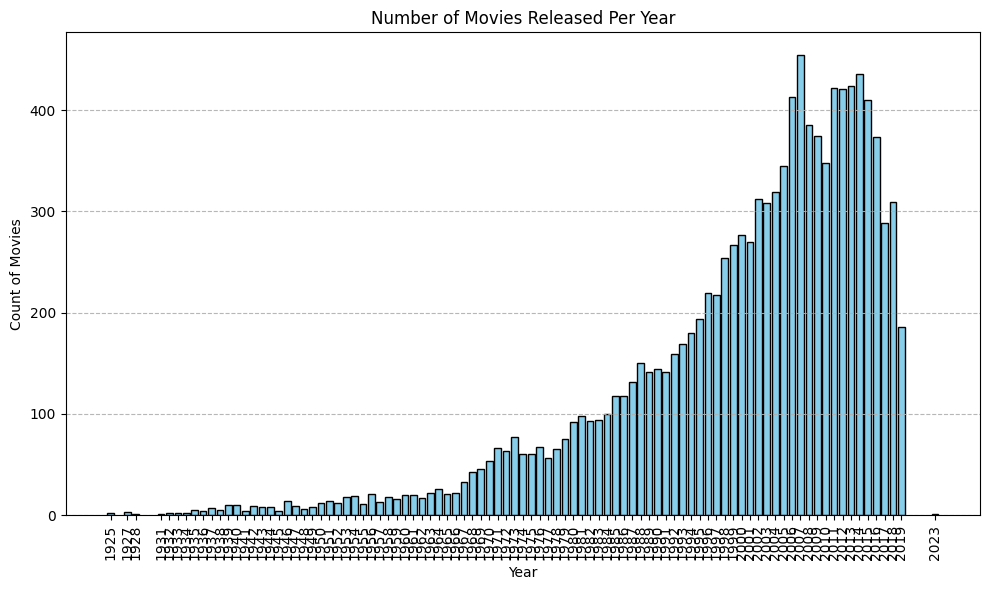

In [16]:
plt.figure(figsize=(3000, 1500))
plt.figure(figsize=(10, 6))
plt.bar(df_count_by_year['release_year_fixed'], df_count_by_year['movie_id'], color='skyblue', edgecolor='black')

plt.title('Number of Movies Released Per Year')
plt.xlabel('Year')
plt.ylabel('Count of Movies')
plt.xticks(df_count_by_year['release_year_fixed'], rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()




### Pre 2010 records

In [17]:
df_no_nulls_pre_2010 = df_no_nulls[ 
                                                    df_no_nulls['release_year_fixed'] < 2010 
                                                ]

df_no_nulls_pre_2010.head()



,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0,1979,1979
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0,2054,1954
5,6,"10,000 B.C.",A young outcast from a primitive tribe is forc...,PG-13,"Action & Adventure, Classics, Drama",Roland Emmerich,2008-03-07,2008-06-24,109.0,8,148,37.0,411087.0,2008,2008
8,9,Charly (A Heartbeat Away),Sam Roberts thinks he has all the answers: the...,PG,"Comedy, Drama, Romance",Adam Thomas Anderegg,2002-09-27,2003-08-01,103.0,20,10,87.0,4819.0,2002,2002
10,19,The Adventures of Mark Twain,"Will Vinton, the stop-motion animation whiz wh...",G,"Action & Adventure, Animation, Kids & Family",Will Vinton,1985-03-01,2006-01-31,86.0,80,5,82.0,1042.0,1985,1985


### Pre 2010 sorted by critic rating

In [18]:
df_no_nulls_pre_2010_sorted_by_rating = df_no_nulls_pre_2010.sort_values(
                                                                    by=['critic_rating'], ascending = False
                                                                 )
df_no_nulls_pre_2010_sorted_by_rating.head()


,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed
2170,2122,A Room With a View,"Set during the Edwardian era of England, A Roo...",R,"Art House & International, Classics, Comedy, D...",James Ivory,1985-12-01,2000-07-04,117.0,100,30,85.0,25426.0,1985,1985
10501,10468,"Nightmares in Red, White and Blue","Nightmares in Red, White and Blue: The Evoluti...",R,"Documentary, Television",Andrew Monument,2009-08-06,2010-09-28,96.0,100,6,78.0,997.0,2009,2009
4418,4390,Citizen Kane,This is the labyrinthine study of the life of ...,PG,"Classics, Drama, Mystery & Suspense",Orson Welles,2041-05-01,2001-09-25,119.0,100,84,90.0,158857.0,2041,1941
14039,14021,The Easy Life (Il sorpasso),"Regarded by many as Dino Risi's finest film, T...",PG,"Art House & International, Comedy, Drama","Dino Risi, Lucio Pellegrini",2062-01-01,2014-04-28,103.0,100,6,94.0,906.0,2062,1962
6194,6160,Five Graves to Cairo,Billy Wilder's Five Graves to Cairo is the thi...,PG,"Drama, Mystery & Suspense",Billy Wilder,2043-01-01,1997-06-10,96.0,100,14,80.0,586.0,2043,1943


### Pre 2010 sorted by audience rating

In [19]:
df_no_nulls_pre_2010_sorted_by_audience_rating = df_no_nulls_pre_2010.sort_values(
                                                                    by=['audience_rating'], ascending = False
                                                                 )

df_no_nulls_pre_2010_sorted_by_audience_rating.head()

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed
14059,14038,The English Surgeon,The English Surgeon' is the true-life tale of ...,PG,"Art House & International, Documentary, Specia...",Geoffrey Smith,2009-07-31,2009-11-03,93.0,89,19,98.0,3602.0,2009,2009
12463,12436,The Shawshank Redemption,"In 1946, a banker named Andy Dufresne (Tim Rob...",R,Drama,Frank Darabont,1994-09-10,1998-01-27,142.0,90,71,98.0,885508.0,1994,1994
6747,6704,The Godfather,Popularly viewed as one of the best American f...,R,Drama,Francis Ford Coppola,1972-03-24,2001-10-09,175.0,98,91,98.0,732931.0,1972,1972
5706,5676,Star Wars: Episode V - The Empire Strikes Back,The second entry in George Lucas' Star Wars tr...,PG,"Action & Adventure, Drama, Science Fiction & F...",Irvin Kershner,1980-06-20,2004-09-21,124.0,95,98,97.0,1055106.0,1980,1980
9306,9257,Love Jones,What do you do after love at first sight? That...,R,"Comedy, Drama, Romance",Theodore Witcher,1997-03-14,1999-07-27,110.0,67,15,97.0,25700.0,1997,1997


### Popular movies based on given logic

In [20]:
average_audience_ratings = df_no_nulls_pre_2010.audience_rating.mean()
df_no_nulls_pre_2010_popular = df_no_nulls_pre_2010[ 
                                                            df_no_nulls_pre_2010['audience_rating'] > average_audience_ratings 
                                                        ]

df_no_nulls_pre_2010_popular.head()


,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0,2054,1954
8,9,Charly (A Heartbeat Away),Sam Roberts thinks he has all the answers: the...,PG,"Comedy, Drama, Romance",Adam Thomas Anderegg,2002-09-27,2003-08-01,103.0,20,10,87.0,4819.0,2002,2002
10,19,The Adventures of Mark Twain,"Will Vinton, the stop-motion animation whiz wh...",G,"Action & Adventure, Animation, Kids & Family",Will Vinton,1985-03-01,2006-01-31,86.0,80,5,82.0,1042.0,1985,1985
11,11,Dark Water,Following up on his horror smash hits Ringu an...,PG-13,"Art House & International, Horror, Mystery & S...",Hideo Nakata,2002-01-19,2005-06-21,100.0,80,15,66.0,21459.0,2002,2002
12,12,The Accused,"Simultaneously gut-wrenching and provocative, ...",R,"Drama, Mystery & Suspense",Jonathan Kaplan,1988-10-14,2002-04-16,110.0,91,22,79.0,20796.0,1988,1988


### Pre 2010 popular sorted by critic and audience ratings

In [21]:
df_no_nulls_pre_2010_popular.sort_values(
                                                                    by=['critic_rating'], ascending = False
                                                                 ).iloc[:5]



,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed
10262,10215,My Father's Glory (La Gloria de Mon Pere),My Father's Glory (La Gloire de Mon Pere) is t...,G,"Art House & International, Drama",Yves Robert,1990-08-29,2003-09-02,110.0,100,5,88.0,4354.0,1990,1990
9737,9687,Meet Me In St. Louis,Sally Benson's short stories about the turn-of...,G,"Classics, Drama, Kids & Family, Musical & Perf...",Vincente Minnelli,2044-11-28,2004-04-06,113.0,100,32,87.0,36996.0,2044,1944
687,673,Rear Window,"Laid up with a broken leg, photojournalist L.B...",PG,"Classics, Drama, Mystery & Suspense",Alfred Hitchcock,2054-09-01,2001-03-06,115.0,100,66,95.0,150539.0,2054,1954
9759,9711,Melvin Goes to Dinner,Mr. Show alumnus Bob Odenkirk's directorial de...,R,Comedy,Bob Odenkirk,2003-11-14,2003-12-16,83.0,100,11,80.0,2737.0,2003,2003
7072,7023,Hamburger Hill,Though the anti-war sentiments of Hamburger Hi...,R,"Action & Adventure, Drama",John Irvin,1987-08-28,2000-02-15,104.0,100,11,72.0,33032.0,1987,1987


In [22]:
df_no_nulls_pre_2010_popular.sort_values(
                                                                    by=['audience_rating'], ascending = False
                                                                 ).iloc[:5]



,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed
6747,6704,The Godfather,Popularly viewed as one of the best American f...,R,Drama,Francis Ford Coppola,1972-03-24,2001-10-09,175.0,98,91,98.0,732931.0,1972,1972
12463,12436,The Shawshank Redemption,"In 1946, a banker named Andy Dufresne (Tim Rob...",R,Drama,Frank Darabont,1994-09-10,1998-01-27,142.0,90,71,98.0,885508.0,1994,1994
14059,14038,The English Surgeon,The English Surgeon' is the true-life tale of ...,PG,"Art House & International, Documentary, Specia...",Geoffrey Smith,2009-07-31,2009-11-03,93.0,89,19,98.0,3602.0,2009,2009
7795,7738,Ikiru,Akira Kurosawa's drama stars Takashi Shimura a...,PG,"Art House & International, Drama",Akira Kurosawa,2056-03-25,2004-01-06,134.0,100,38,97.0,20261.0,2056,1956
4435,4407,Cidade de Deus (City of God),Fernando Meirelles' City of God is a sweeping ...,R,"Action & Adventure, Art House & International,...","Fernando Meirelles, K√°tia Lund",2003-01-17,2004-06-08,130.0,91,159,97.0,251959.0,2003,2003


### Popular movie percentages by movie ratings

In [23]:
df_no_nulls_pre_2010_popular.groupby( ['rating'] )['movie_id'].count().reset_index()



,rating,movie_id
0,G,402
1,NC17,22
2,PG,841
3,PG-13,853
4,R,1970


In [24]:
total_movies_with_ratings = df_no_nulls_pre_2010_popular.groupby( ['rating'] )['movie_id'].count().reset_index()['movie_id'].sum()
total_movies_with_ratings


4088

In [25]:
df_no_nulls_pre_2010_popular_movie_percentage = df_no_nulls_pre_2010_popular.groupby( ['rating'] )['movie_id'].count().reset_index()      
df_no_nulls_pre_2010_popular_movie_percentage['percentage_movies_by_rating'] = (df_no_nulls_pre_2010_popular_movie_percentage['movie_id'] / total_movies_with_ratings) * 100
df_no_nulls_pre_2010_popular_movie_percentage.drop(columns=['movie_id'], inplace=True)
df_no_nulls_pre_2010_popular_movie_percentage.head()


,rating,percentage_movies_by_rating
0,G,9.833659
1,NC17,0.538160
2,PG,20.572407
3,PG-13,20.865949
4,R,48.189824


In [26]:
df_no_nulls_pre_2010_popular_with_movie_percent_by_rating = df_no_nulls_pre_2010_popular.merge(
                                                                                        df_no_nulls_pre_2010_popular_movie_percentage, on = ['rating'], how = 'left'
                                                                                     )

df_no_nulls_pre_2010_popular_with_movie_percent_by_rating.head()

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed,percentage_movies_by_rating
0,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0,2054,1954,9.833659
1,9,Charly (A Heartbeat Away),Sam Roberts thinks he has all the answers: the...,PG,"Comedy, Drama, Romance",Adam Thomas Anderegg,2002-09-27,2003-08-01,103.0,20,10,87.0,4819.0,2002,2002,20.572407
2,19,The Adventures of Mark Twain,"Will Vinton, the stop-motion animation whiz wh...",G,"Action & Adventure, Animation, Kids & Family",Will Vinton,1985-03-01,2006-01-31,86.0,80,5,82.0,1042.0,1985,1985,9.833659
3,11,Dark Water,Following up on his horror smash hits Ringu an...,PG-13,"Art House & International, Horror, Mystery & S...",Hideo Nakata,2002-01-19,2005-06-21,100.0,80,15,66.0,21459.0,2002,2002,20.865949
4,12,The Accused,"Simultaneously gut-wrenching and provocative, ...",R,"Drama, Mystery & Suspense",Jonathan Kaplan,1988-10-14,2002-04-16,110.0,91,22,79.0,20796.0,1988,1988,48.189824


### Pair-plots and related insights

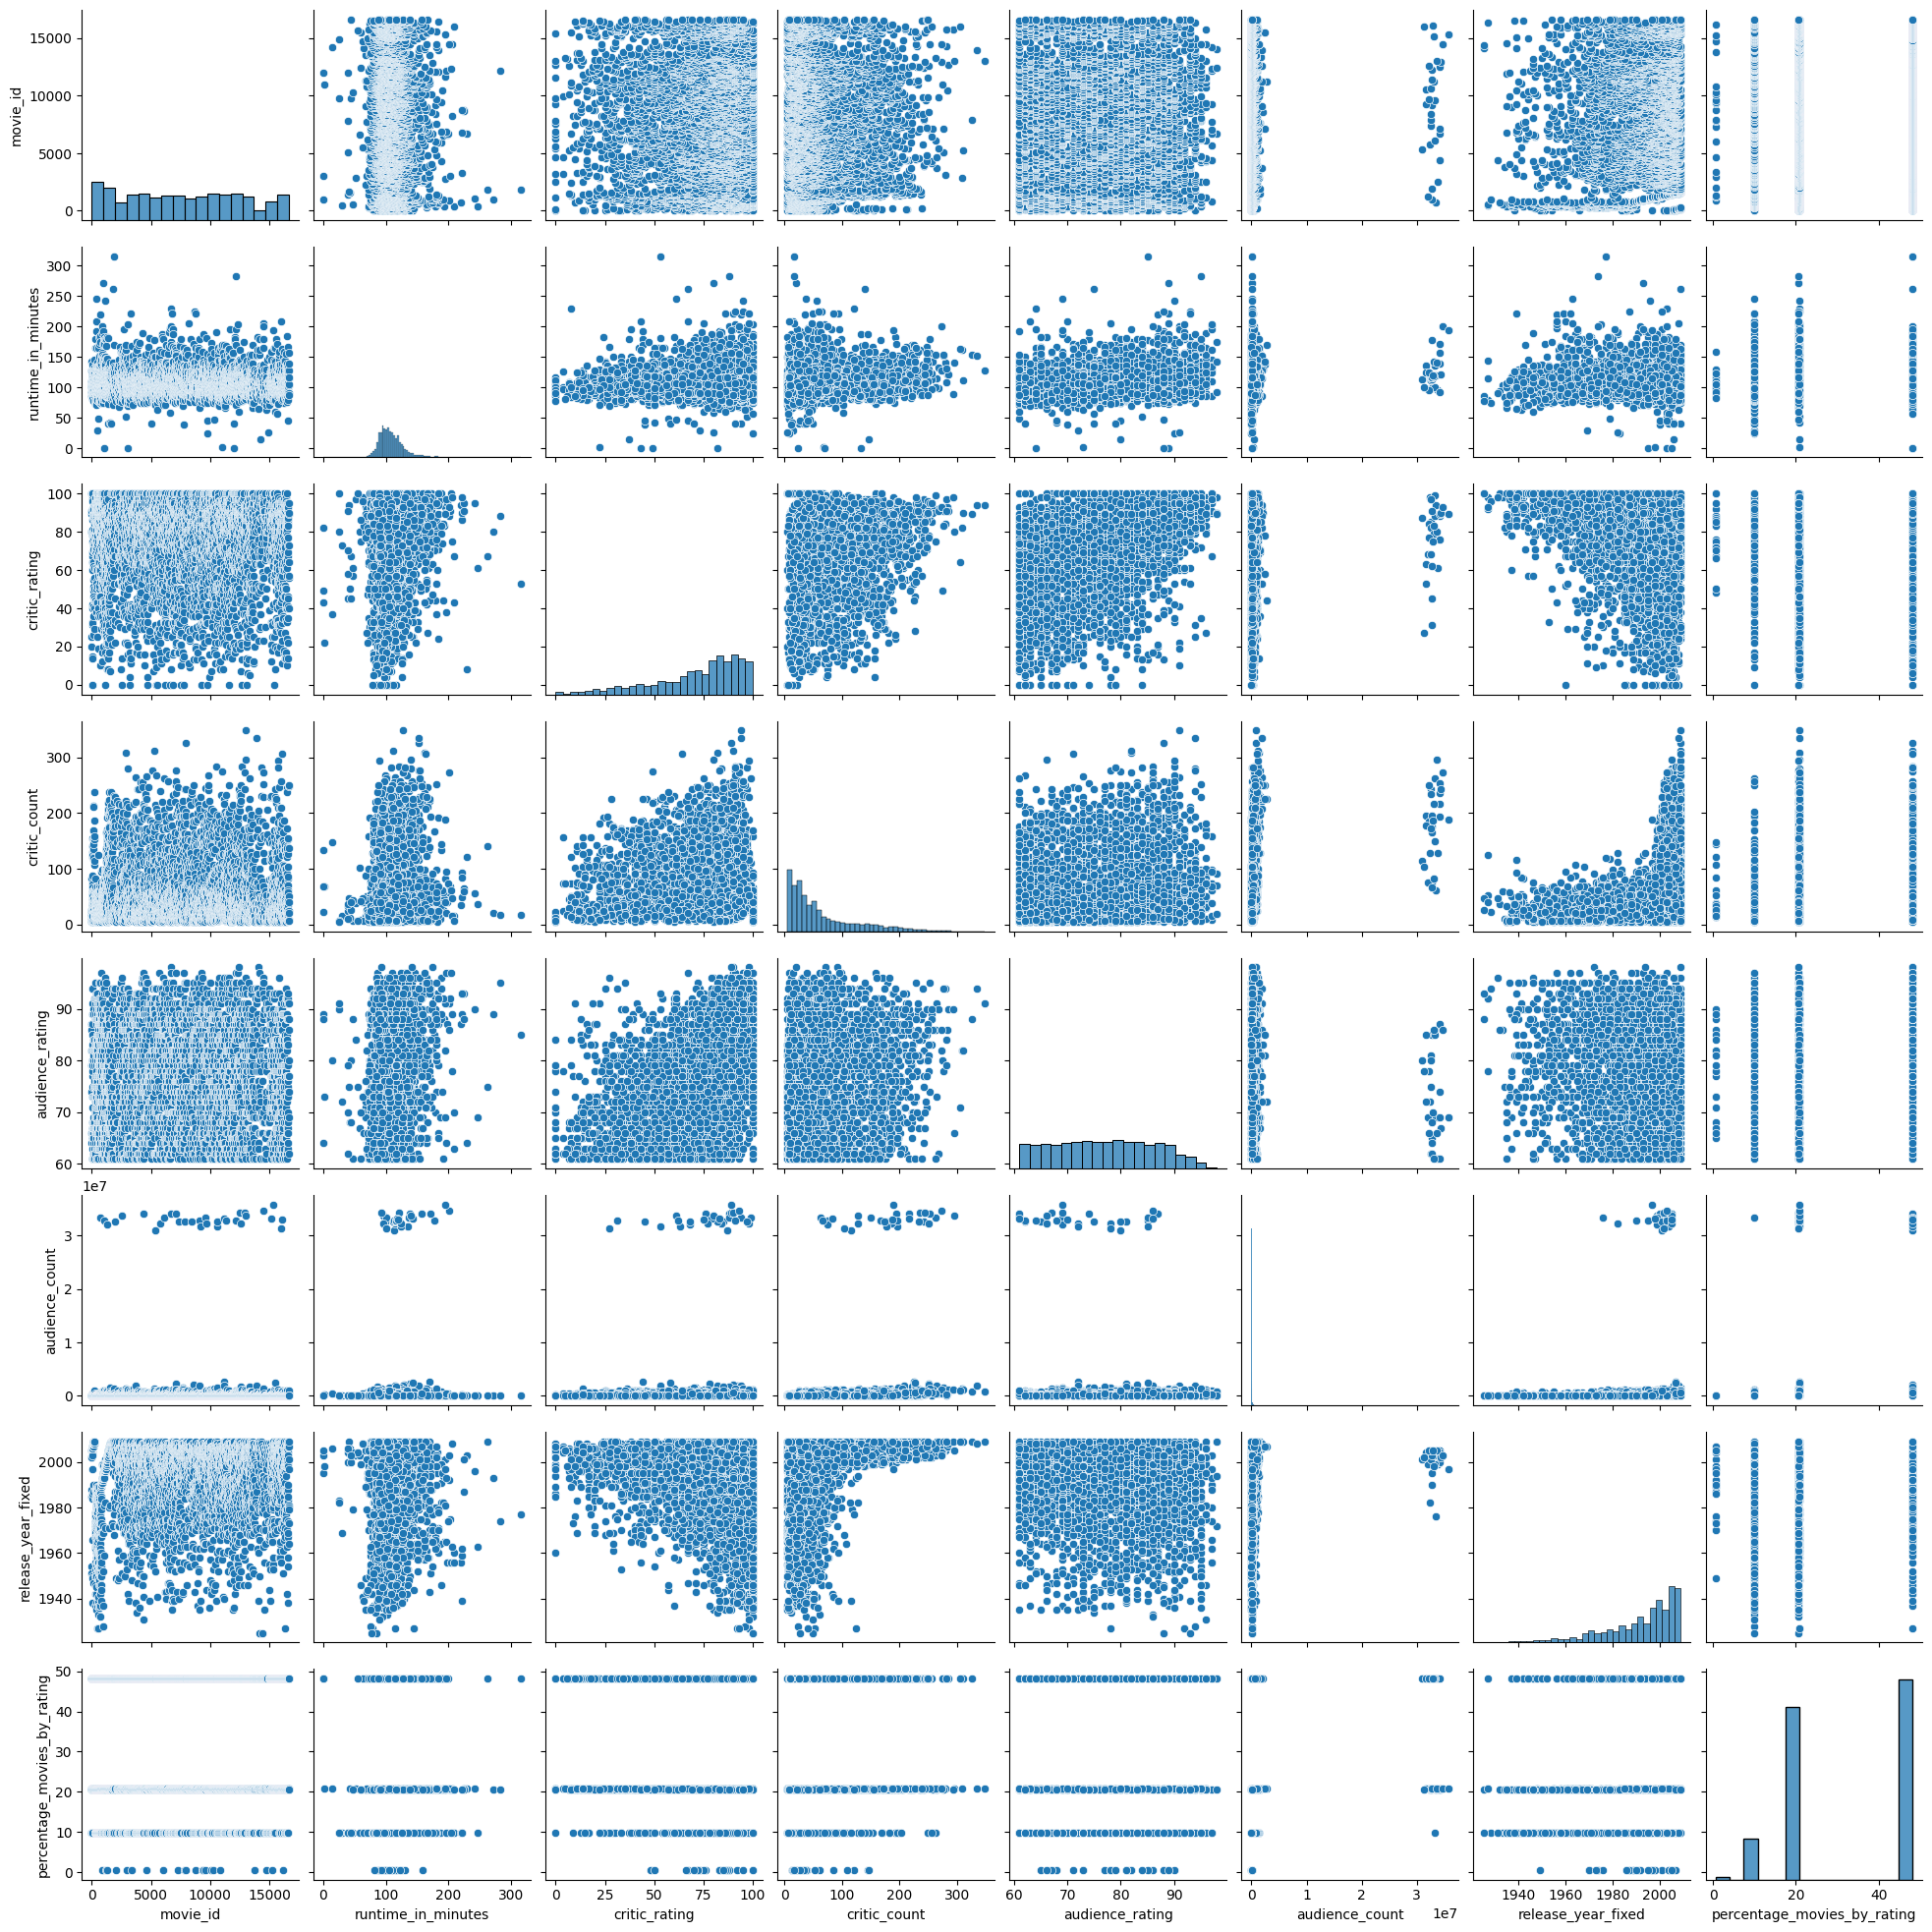

In [27]:
sns.pairplot(df_no_nulls_pre_2010_popular_with_movie_percent_by_rating)
plt.show()


#### Scatter plot for runtime_in_minutes vs critic_rating has an increasing funnel shape. 
##### - Variability in runtime increases with increase in critic ratings, whereas there is relatively lower variability in runtime for the low rated movies.

##### - No clear correlation is visible however.

#### Audience count vs critic count ---> Most movies have lower audience count with the exception of a few with high audience counts, whereas, the count of critic viewership has more variance.


####  There is no correlation between runtime and audience ratings going by their scatter-plot, since if we were to draw a line through the scatter, it would come parallel to the x-axis.



### Part 3 - Feature Engineering

In [28]:

df_no_nulls_pre_2010.head()



,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0,1979,1979
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0,2054,1954
5,6,"10,000 B.C.",A young outcast from a primitive tribe is forc...,PG-13,"Action & Adventure, Classics, Drama",Roland Emmerich,2008-03-07,2008-06-24,109.0,8,148,37.0,411087.0,2008,2008
8,9,Charly (A Heartbeat Away),Sam Roberts thinks he has all the answers: the...,PG,"Comedy, Drama, Romance",Adam Thomas Anderegg,2002-09-27,2003-08-01,103.0,20,10,87.0,4819.0,2002,2002
10,19,The Adventures of Mark Twain,"Will Vinton, the stop-motion animation whiz wh...",G,"Action & Adventure, Animation, Kids & Family",Will Vinton,1985-03-01,2006-01-31,86.0,80,5,82.0,1042.0,1985,1985


In [29]:
df_no_nulls_post_and_including_2010 = df_no_nulls[ 
                                                    df_no_nulls['release_year_fixed'] >= 2010 
                                      ]

df_no_nulls_post_and_including_2010.head()



,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year,release_year_fixed
0,1,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,2010-02-12,2010-06-29,83.0,49,144,53.0,254287.0,2010,2010
1,2,Please Give,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,2010-04-30,2010-10-19,90.0,86,140,64.0,11567.0,2010,2010
101,98,Fireflies in the Garden,"To an outsider, the Taylors are the very pictu...",R,Drama,Dennis Lee (III),2011-10-14,2012-02-07,98.0,22,54,45.0,45150.0,2011,2011
134,2956,The Back-up Plan,A romantic comedy centered on a woman who conc...,PG-13,"Comedy, Romance",Alan Poul,2010-04-23,2010-08-24,104.0,18,145,46.0,135533.0,2010,2010
136,131,The Oxford Murders,When an elderly woman is viciously murdered in...,R,"Art House & International, Drama, Horror, Myst...",√Ålex de la Iglesia,2010-08-06,2010-10-05,110.0,9,11,33.0,14548.0,2010,2010


In [30]:
training_data = df_no_nulls_pre_2010.copy()
test_data = df_no_nulls_post_and_including_2010.copy()
training_data_relevant_fields = training_data[ ['genre', 'runtime_in_minutes', 'rating', 'critic_rating', 'release_year_fixed', 'in_theaters_date'] ]
training_data_relevant_fields.head()



,genre,runtime_in_minutes,rating,critic_rating,release_year_fixed,in_theaters_date
2,"Comedy, Romance",118.0,R,68,1979,1979-10-05
4,"Action & Adventure, Drama, Kids & Family",127.0,G,89,1954,2054-01-01
5,"Action & Adventure, Classics, Drama",109.0,PG-13,8,2008,2008-03-07
8,"Comedy, Drama, Romance",103.0,PG,20,2002,2002-09-27
10,"Action & Adventure, Animation, Kids & Family",86.0,G,80,1985,1985-03-01


In [31]:
training_data_relevant_fields.genre.unique()

array(['Comedy, Romance', 'Action & Adventure, Drama, Kids & Family',
       'Action & Adventure, Classics, Drama', 'Comedy, Drama, Romance',
       'Action & Adventure, Animation, Kids & Family',
       'Art House & International, Horror, Mystery & Suspense',
       'Drama, Mystery & Suspense', 'Drama',
       'Art House & International, Drama, Faith & Spirituality',
       'Documentary, Special Interest',
       'Action & Adventure, Classics, Romance',
       'Comedy, Horror, Mystery & Suspense', 'Comedy',
       'Art House & International, Drama',
       'Drama, Science Fiction & Fantasy, Romance',
       'Action & Adventure, Drama, Mystery & Suspense',
       'Action & Adventure, Drama, Horror, Science Fiction & Fantasy',
       'Action & Adventure, Documentary, Drama, Special Interest',
       'Animation, Kids & Family, Science Fiction & Fantasy', 'Horror',
       'Horror, Mystery & Suspense',
       'Action & Adventure, Comedy, Drama, Mystery & Suspense',
       'Art House & Inte

In [32]:
tdnn = training_data_relevant_fields[ ['genre'] ] 
one_hot_encoded_df = tdnn['genre'].str.get_dummies(sep=', ')

In [33]:
training_data_with_one_hot_encoded_genres = pd.concat([training_data_relevant_fields, one_hot_encoded_df], axis=1)
training_data_with_one_hot_encoded_genres.drop(columns = ['genre'], inplace = True)
training_data_with_one_hot_encoded_genres.head()

,runtime_in_minutes,rating,critic_rating,release_year_fixed,in_theaters_date,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,...,Horror,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western
2,118.0,R,68,1979,1979-10-05,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,127.0,G,89,1954,2054-01-01,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,109.0,PG-13,8,2008,2008-03-07,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,103.0,PG,20,2002,2002-09-27,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10,86.0,G,80,1985,1985-03-01,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [34]:
training_data_with_one_hot_encoded_genres['kid_friendly'] = training_data_with_one_hot_encoded_genres['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)



### Creating the additional predictors

In [35]:
def decade_from_year(year):
    return (year // 10) * 10


In [36]:

training_data_with_one_hot_encoded_genres['release_decade'] = training_data_with_one_hot_encoded_genres.release_year_fixed.apply( lambda x: decade_from_year(x) )
training_data_with_one_hot_encoded_genres['how_many_decades_relative_to_2020'] = (2020 - training_data_with_one_hot_encoded_genres.release_year_fixed.apply( lambda x: decade_from_year(x) ))/10
training_data_with_one_hot_encoded_genres['adult_rated'] = training_data_with_one_hot_encoded_genres['rating'].apply(lambda x: 1 if x in ['R'] else 0)
training_data_with_one_hot_encoded_genres['month_of_year'] = training_data_with_one_hot_encoded_genres.in_theaters_date.apply(lambda x: int( x.split('-')[1] ) )



In [37]:
training_data_with_one_hot_encoded_genres[ ['release_decade', 'how_many_decades_relative_to_2020'] ]

,release_decade,how_many_decades_relative_to_2020
2,1970,5.0
4,1950,7.0
5,2000,2.0
8,2000,2.0
10,1980,4.0
...,...,...
16628,2000,2.0
16631,2000,2.0
16633,2000,2.0
16636,1960,6.0


### Repeating the steps for test data

In [38]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3618 entries, 0 to 16634
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            3618 non-null   int64  
 1   movie_title         3618 non-null   object 
 2   movie_info          3618 non-null   object 
 3   rating              3618 non-null   object 
 4   genre               3618 non-null   object 
 5   directors           3618 non-null   object 
 6   in_theaters_date    3618 non-null   object 
 7   on_streaming_date   3618 non-null   object 
 8   runtime_in_minutes  3618 non-null   float64
 9   critic_rating       3618 non-null   int64  
 10  critic_count        3618 non-null   int64  
 11  audience_rating     3618 non-null   float64
 12  audience_count      3618 non-null   float64
 13  release_year        3618 non-null   object 
 14  release_year_fixed  3618 non-null   int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 452.2+ KB


In [39]:
test_data_relevant_fields = test_data[  ['genre', 'rating', 'runtime_in_minutes', 'critic_rating', 'release_year_fixed', 'in_theaters_date'] ]


In [40]:
tdnn = test_data_relevant_fields[ ['genre'] ] 
one_hot_encoded_df = tdnn['genre'].str.get_dummies(sep=', ')
one_hot_encoded_df


,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,Documentary,Drama,Faith & Spirituality,...,Horror,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western
0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
134,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
136,0,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16624,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
16629,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
16630,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
16632,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
test_data_with_one_hot_encoded_genres = pd.concat([test_data_relevant_fields, one_hot_encoded_df], axis=1)
test_data_with_one_hot_encoded_genres.head()


,genre,rating,runtime_in_minutes,critic_rating,release_year_fixed,in_theaters_date,Action & Adventure,Animation,Anime & Manga,Art House & International,...,Horror,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western
0,"Action & Adventure, Comedy, Drama, Science Fic...",PG,83.0,49,2010,2010-02-12,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Comedy,R,90.0,86,2010,2010-04-30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,Drama,R,98.0,22,2011,2011-10-14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,"Comedy, Romance",PG-13,104.0,18,2010,2010-04-23,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
136,"Art House & International, Drama, Horror, Myst...",R,110.0,9,2010,2010-08-06,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0


In [42]:
test_data_with_one_hot_encoded_genres.drop(columns = ['genre'], inplace = True)

In [43]:
test_data_with_one_hot_encoded_genres['kid_friendly'] = test_data_with_one_hot_encoded_genres['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)



### Creating the additional predictors

In [44]:

test_data_with_one_hot_encoded_genres['release_decade'] = test_data_with_one_hot_encoded_genres.release_year_fixed.apply( lambda x: decade_from_year(x) )
test_data_with_one_hot_encoded_genres['how_many_decades_relative_to_2020'] = (2020 - test_data_with_one_hot_encoded_genres.release_year_fixed.apply( lambda x: decade_from_year(x) ))/10
test_data_with_one_hot_encoded_genres['adult_rated'] = test_data_with_one_hot_encoded_genres['rating'].apply(lambda x: 1 if x in ['R'] else 0)
test_data_with_one_hot_encoded_genres['month_of_year'] = test_data_with_one_hot_encoded_genres.in_theaters_date.apply(lambda x: int( x.split('-')[1] ) )



In [45]:
test_data_with_one_hot_encoded_genres[ ['release_decade', 'how_many_decades_relative_to_2020'] ]

,release_decade,how_many_decades_relative_to_2020
0,2010,1.0
1,2010,1.0
101,2010,1.0
134,2010,1.0
136,2010,1.0
...,...,...
16624,2010,1.0
16629,2010,1.0
16630,2010,1.0
16632,2010,1.0


In [46]:
training_data_with_one_hot_encoded_genres.drop( columns = ['rating'], inplace = True )
test_data_with_one_hot_encoded_genres.drop( columns = ['rating'], inplace = True )

In [47]:
def train_the_model_and_return_coeffs(data_with_one_hot_encoded_genres, predictors_list = [], exclusion_list = []):

    # Initialize the scaler
    scaler = StandardScaler()
    
    # Perform scaling on the 'runtime_in_minutes' column
    data_with_one_hot_encoded_genres['runtime_in_minutes_scaled'] = scaler.fit_transform(data_with_one_hot_encoded_genres[['runtime_in_minutes']])
    
    # Initialize the linear regression model
    model = LinearRegression()
    
    # Features and target variable
    if len(predictors_list)>0:
        X = data_with_one_hot_encoded_genres.drop(columns = exclusion_list)[ predictors_list ]
    else:
        X = data_with_one_hot_encoded_genres.drop(columns = exclusion_list)
        for col in X.columns:
            print(col)
    
    y = data_with_one_hot_encoded_genres['critic_rating']
    
    # Fit the model
    model.fit(X, y)
    
    # Output the coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_
    
    print("Coefficients:", coefficients)
    print("Intercept:", intercept)
    
    return coefficients, intercept, model

### With only one predictor

In [48]:

coefficients, intercept, model_one = train_the_model_and_return_coeffs(
                                    training_data_with_one_hot_encoded_genres, predictors_list = ['runtime_in_minutes_scaled'],
                                    exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_decade', 'release_year_fixed', 'month_of_year', 'adult_rated', 'in_theaters_date', 'how_many_decades_relative_to_2020']    
                                 )


Coefficients: [3.88490574]
Intercept: 55.83268633540373


### With 2 predictors

In [49]:

coefficients, intercept, model_two = train_the_model_and_return_coeffs(
                                    training_data_with_one_hot_encoded_genres, predictors_list = ['runtime_in_minutes_scaled', 'kid_friendly'],
                                    exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_decade', 'release_year_fixed', 'month_of_year', 'adult_rated', 'in_theaters_date', 'how_many_decades_relative_to_2020']    

                                 )


Coefficients: [4.00575668 8.9962132 ]
Intercept: 53.385734970902554


### With all the predictors

In [50]:

coefficients, intercept, model_all = train_the_model_and_return_coeffs(
                                    training_data_with_one_hot_encoded_genres, predictors_list = [],
                                    exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_decade', 'release_year_fixed', 'month_of_year', 'adult_rated', 'in_theaters_date', 'how_many_decades_relative_to_2020']
                                 )


Action & Adventure
Animation
Anime & Manga
Art House & International
Classics
Comedy
Cult Movies
Documentary
Drama
Faith & Spirituality
Gay & Lesbian
Horror
Kids & Family
Musical & Performing Arts
Mystery & Suspense
Romance
Science Fiction & Fantasy
Special Interest
Sports & Fitness
Television
Western
kid_friendly
runtime_in_minutes_scaled
Coefficients: [ -5.00704901  12.61573467  -8.66822854  11.50773291  19.4056003
  -3.72816899   3.96747476  20.17572149   9.36641843 -17.95083859
   1.08505686  -4.00477402  -5.10713256   3.25640433  -1.65639131
   0.6073467    1.86551031   8.35406125   6.43807244   2.45620325
   7.25803146   6.2396531    2.88277612]
Intercept: 47.2951580547053


In [51]:
len(coefficients)

23

In [52]:
# training_data_with_one_hot_encoded_genres.info()

In [53]:
def calculate_model_performance_metrics(y_test, y_pred):
    # Calculate R2 (Coefficient of Determination)
    r2 = r2_score(y_test, y_pred)
    
    # Calculate MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print the results
    print(f"R2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")

### Repeating the steps for test data to test the models

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Initialize the scaler for the 'runtime_in_minutes' from training data
scaler = StandardScaler()

# Fit the scaler on the training data (you should have this from your training phase)
scaler.fit(test_data_with_one_hot_encoded_genres[['runtime_in_minutes']])

# Apply scaling on the 'runtime_in_minutes' of test_data
test_data_with_one_hot_encoded_genres['runtime_in_minutes_scaled'] = scaler.transform(test_data_with_one_hot_encoded_genres[['runtime_in_minutes']])

test_data_with_one_hot_encoded_genres = test_data_with_one_hot_encoded_genres.dropna()

exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_decade', 'release_year_fixed', 'month_of_year', 'adult_rated', 'in_theaters_date', 'how_many_decades_relative_to_2020']

# Use the trained model to predict on the prepared test data
y_preds_one = model_one.predict( test_data_with_one_hot_encoded_genres.drop(columns = exclusion_list)[ ['runtime_in_minutes_scaled'] ]  )
y_preds_two = model_two.predict( test_data_with_one_hot_encoded_genres.drop(columns = exclusion_list)[ ['runtime_in_minutes_scaled', 'kid_friendly'] ]  )
y_preds_all = model_all.predict( test_data_with_one_hot_encoded_genres.drop(columns = exclusion_list)  )

y_test = test_data_with_one_hot_encoded_genres['critic_rating'].copy()

# Output the predictions
print("Predicted critic ratings:", y_preds_one)
print("Predicted critic ratings:", y_preds_two)
print("Predicted critic ratings:", y_preds_all)

print("MODEL 1")
print("\n\n")
calculate_model_performance_metrics(y_test, y_preds_one)
print("MODEL 2")
print("\n\n")
calculate_model_performance_metrics(y_test, y_preds_two)
print("MODEL All")
print("\n\n")
calculate_model_performance_metrics(y_test, y_preds_all)


Predicted critic ratings: [50.94455544 52.63512193 54.56719792 ... 55.29172642 55.53323592
 56.98229291]
Predicted critic ratings: [57.34175819 50.08870132 52.08087997 ... 61.82416017 53.0769693
 63.5673165 ]
Predicted critic ratings: [52.40430725 41.19425137 55.72252673 ... 50.0125721  43.34478328
 58.26838801]
MODEL 1



R2 Score: 0.019689188257554724
Mean Absolute Error: 24.447187829789073
Root Mean Squared Error: 28.192522876547457
MODEL 2



R2 Score: 0.032597212133004816
Mean Absolute Error: 24.296046867127643
Root Mean Squared Error: 28.006298450897763
MODEL All



R2 Score: 0.12047584753329488
Mean Absolute Error: 22.684240773213148
Root Mean Squared Error: 26.703976079348884


In [53]:

def get_high_and_low_value_predictors(model):
    # Get predictors with p-value > 0.05
    high_pvalue_predictors = model.pvalues[model.pvalues > 0.05].index.tolist()
    
    # Get predictors with p-value < 0.05
    low_pvalue_predictors = model.pvalues[model.pvalues < 0.05].index.tolist()
    
    print("Predictors with p-value > 0.05:", high_pvalue_predictors)
    print("Predictors with p-value < 0.05:", low_pvalue_predictors)

In [54]:

# Add a constant term to each model (required for statsmodels OLS)
X1 = sm.add_constant(  training_data_with_one_hot_encoded_genres.drop(columns = exclusion_list)[ ['runtime_in_minutes_scaled'] ]  )
X2 = sm.add_constant( training_data_with_one_hot_encoded_genres.drop(columns = exclusion_list)[ ['runtime_in_minutes_scaled', 'kid_friendly'] ] )
X3 = sm.add_constant(  training_data_with_one_hot_encoded_genres.drop(columns = exclusion_list) )

y = training_data_with_one_hot_encoded_genres['critic_rating']

# Fit the models
model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()

print("\n\n\n")
# Print p-values for each model
print("Model 1 p-values:")
# print(model1.pvalues)

get_high_and_low_value_predictors(model1)

print("\n\n\n")


print("\nModel 2 p-values:")
# print(model2.pvalues)
get_high_and_low_value_predictors(model2)
print("\n\n\n")

print("\nModel 3 p-values:")
get_high_and_low_value_predictors(model3)
# print(model3.pvalues)






Model 1 p-values:
Predictors with p-value > 0.05: []
Predictors with p-value < 0.05: ['const', 'runtime_in_minutes_scaled']





Model 2 p-values:
Predictors with p-value > 0.05: []
Predictors with p-value < 0.05: ['const', 'runtime_in_minutes_scaled', 'kid_friendly']





Model 3 p-values:
Predictors with p-value > 0.05: ['Anime & Manga', 'Cult Movies', 'Gay & Lesbian', 'Romance', 'Television']
Predictors with p-value < 0.05: ['const', 'Action & Adventure', 'Animation', 'Art House & International', 'Classics', 'Comedy', 'Documentary', 'Drama', 'Faith & Spirituality', 'Horror', 'Kids & Family', 'Musical & Performing Arts', 'Mystery & Suspense', 'Science Fiction & Fantasy', 'Special Interest', 'Sports & Fitness', 'Western', 'kid_friendly', 'runtime_in_minutes_scaled']


### Let us drop these predictors with p-value > 0.05: 
### ['Anime & Manga', 'Cult Movies', 'Gay & Lesbian', 'Romance', 'Television']

### Trying out other models

### I created 3 new variables

##### - release_decade - Opinions regarding movies based on their subjects/topics can change over time, as society itself undergoes many transformations
##### - month_of_year - Could season (or time of year) have any bearing on a critic's movie experience and hence the review. Do not expect this to be a significant inclusion
##### - adult_rated - Is it possible that adult-rated movies are usually not that well rated compared to their counterparts?



### Let's start with all 3 including the already recommended features

### Including -> 'how_many_decades_relative_to_2020' + 'month_of_year' + 'adult_rated'

In [55]:
# exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_year_fixed', 'in_theaters_date']
exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_year_fixed', 'in_theaters_date', 'release_decade'] + ['Anime & Manga', 'Cult Movies', 'Gay & Lesbian', 'Romance', 'Television']

coefficients, intercept, model_1_of_3 = train_the_model_and_return_coeffs(
                                            training_data_with_one_hot_encoded_genres, 
                                            predictors_list = [], 
                                            exclusion_list = exclusion_list
                                        )
y_preds_all_1_of_3 = model_1_of_3.predict( test_data_with_one_hot_encoded_genres.drop(columns = exclusion_list)  )
y_test = test_data_with_one_hot_encoded_genres['critic_rating'].copy()

# Output the predictions
print("Predicted critic ratings:", y_preds_all_1_of_3)
calculate_model_performance_metrics(y_test, y_preds_all_1_of_3)


Action & Adventure
Animation
Art House & International
Classics
Comedy
Documentary
Drama
Faith & Spirituality
Horror
Kids & Family
Musical & Performing Arts
Mystery & Suspense
Science Fiction & Fantasy
Special Interest
Sports & Fitness
Western
kid_friendly
how_many_decades_relative_to_2020
adult_rated
month_of_year
runtime_in_minutes_scaled
Coefficients: [ -5.38428063  13.8828592   11.71780316   4.38974389  -2.85441186
  24.27005892   9.00666773 -15.20266842  -6.22569906  -2.57783776
   1.7152      -2.2484489    1.75095749   8.05806135   7.87024786
   4.68184255   4.16565614   5.80334494   4.99380863   0.39558833
   2.89497168]
Intercept: 26.119328164235974
Predicted critic ratings: [35.7558791  33.26164766 48.93601039 ... 35.59992074 29.63629209
 43.77592999]
R2 Score: -0.008010447967822243
Mean Absolute Error: 24.156049287909944
Root Mean Squared Error: 28.58805191325987


### An r2 score of -0.008

### Getting rid of year_of_month first as it was an experimental feature to include in the first place

### Including -> 'how_many_decades_relative_to_2020' + 'adult_rated'

In [56]:
# exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_year_fixed', 'in_theaters_date']
exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_year_fixed', 'in_theaters_date', 'month_of_year', 'release_decade'] + ['Anime & Manga', 'Cult Movies', 'Gay & Lesbian', 'Romance', 'Television']

coefficients, intercept, model_2_of_3 = train_the_model_and_return_coeffs(
                                            training_data_with_one_hot_encoded_genres, 
                                            predictors_list = [], 
                                            exclusion_list = exclusion_list
                                        )
y_preds_all_2_of_3 = model_2_of_3.predict( test_data_with_one_hot_encoded_genres.drop(columns = exclusion_list)  )
y_test = test_data_with_one_hot_encoded_genres['critic_rating'].copy()

# Output the predictions
print("Predicted critic ratings:", y_preds_all_2_of_3)
calculate_model_performance_metrics(y_test, y_preds_all_2_of_3)


Action & Adventure
Animation
Art House & International
Classics
Comedy
Documentary
Drama
Faith & Spirituality
Horror
Kids & Family
Musical & Performing Arts
Mystery & Suspense
Science Fiction & Fantasy
Special Interest
Sports & Fitness
Western
kid_friendly
how_many_decades_relative_to_2020
adult_rated
runtime_in_minutes_scaled
Coefficients: [ -5.520541    13.93066465  11.59645334   4.19946849  -2.95722416
  24.26768353   9.09722607 -15.21486626  -6.32621983  -2.43822899
   1.77107518  -2.36785095   1.89015918   7.77115531   7.84070718
   4.52963554   4.12509497   5.7629992    4.95737878   3.02494137]
Intercept: 28.954193536050916
Predicted critic ratings: [37.54581562 34.22759715 47.78643822 ... 35.46385074 31.52680463
 45.19031637]
R2 Score: -0.006253196094114122
Mean Absolute Error: 24.160384627650487
Root Mean Squared Error: 28.56312244892746


### An r2 score of -0.006

### Getting rid of adult_rated as well (might be correlated with kid_friendly which is already included in the model), and sticking only to release_decade

### Including -> 'how_many_decades_relative_to_2020'

In [57]:
# exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_year_fixed', 'in_theaters_date']
exclusion_list = ['critic_rating', 'runtime_in_minutes', 'release_year_fixed', 'in_theaters_date', 'month_of_year', 'adult_rated', 'release_decade'] + ['Anime & Manga', 'Cult Movies', 'Gay & Lesbian', 'Romance', 'Television']

coefficients, intercept, model_3_of_3 = train_the_model_and_return_coeffs(
                                            training_data_with_one_hot_encoded_genres, 
                                            predictors_list = [], 
                                            exclusion_list = exclusion_list
                                        )
y_preds_all_3_of_3 = model_3_of_3.predict( test_data_with_one_hot_encoded_genres.drop(columns = exclusion_list)  )
y_test = test_data_with_one_hot_encoded_genres['critic_rating'].copy()

# Output the predictions
print("Predicted critic ratings:", y_preds_all_3_of_3)
calculate_model_performance_metrics(y_test, y_preds_all_3_of_3)


Action & Adventure
Animation
Art House & International
Classics
Comedy
Documentary
Drama
Faith & Spirituality
Horror
Kids & Family
Musical & Performing Arts
Mystery & Suspense
Science Fiction & Fantasy
Special Interest
Sports & Fitness
Western
kid_friendly
how_many_decades_relative_to_2020
runtime_in_minutes_scaled
Coefficients: [ -5.64522255  13.92842265  12.02219525   3.69752094  -3.27754389
  24.28547058   9.44085456 -15.94056057  -5.48577198  -2.20337965
   1.66225701  -1.95759499   1.35267781   7.89657818   7.73932691
   4.60754602   0.84236587   5.93274527   2.96153551]
Intercept: 31.607482568810504
Predicted critic ratings: [36.52704703 31.82512146 46.01637717 ... 34.69266606 34.03440735
 44.26461628]
R2 Score: -0.017723709765553153
Mean Absolute Error: 24.33729809344492
Root Mean Squared Error: 28.725459959402492


### An r2 score of -0.017

### 3 other things to improve the model

##### - Evaluate p-values for each model and drop the unnecessary predictors using the exclusion list parameter
##### - Merge some of the genres into broader categories to reduce total predictors and hence model complexity.
##### - Treat "release decade" as a categorical variable, and consider using that instead of 'how many decades relative to 2020'.
##### - Additionally, for the numerical predictor(s), plot a correlation plot with the critic_rating column to evaluate its usefulness.
